<a href="https://colab.research.google.com/github/AbrahamB2603/IAyRN/blob/Main/DEFINITIVO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abraham Giovanni Aguirre Bravo - 2014222 - Martes N4

# Ramiro Emiliano Martinez De La Cruz - 2014197 - Martes N4

# María Fernanda Garza Barbosa - 1945003 - Martes N4

# Karla Judith Corona Castro - 1923390 - Martes N4

# PIA de Inteligencia Artificial y Redes Neuronales.
# Proyecto de Acciones por Lenguaje de señas mexicanas.

# Introducción

Este proyecto tiene como objetivo apoyar a las personas con discapacidad del habla, facilitando su interacción con quienes no comparten su forma de comunicación. Se desarrolló una herramienta que interpreta el lenguaje de señas mexicano mediante una red neuronal convolucional entrenada con imágenes almacenadas en Google Drive. Usando una cámara y servomotores, el sistema capta e interpreta con precisión los gestos de las manos, traduciéndolos en acciones o mensajes que reflejen pensamientos y emociones. De esta manera, se reduce la barrera comunicativa y se promueve una interacción inclusiva y accesible para todos.

# Librerias

In [4]:
# ============================
# 1. Importar Librerías
# ============================
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

# Importamos librerías para el método de captura vía JavaScript en Colab.
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Librería para montar Google Drive en Colab.
from google.colab import drive

# Preprocesamiento

In [5]:
# ============================
# 2. Montar Google Drive y Preprocesamiento
# ============================
# Montamos Google Drive para acceder al dataset.
drive.mount('/content/drive')

# Definimos la ruta al dataset en Drive.
# Se asume que tu dataset está organizado en:
# /content/drive/MyDrive/Datasets/Dataset/
# y que dentro existen subcarpetas (ej. 1, 2, 3, 4)
DATASET_PATH = "/content/drive/MyDrive/Datasets/Dataset"

# Verifica si la ruta existe para diagnosticar problemas.
if not os.path.exists(DATASET_PATH):
    print(f"Error: La ruta del dataset no existe: {DATASET_PATH}")
else:
    print("Contenido de la carpeta Dataset:", os.listdir(DATASET_PATH))

# Parámetros de preprocesamiento.
IMG_SIZE = (128,128)  # Se reduce la resolución para acelerar el entrenamiento.
BATCH_SIZE = 32       # Batch size moderado.

# Crea el dataset de entrenamiento y validación usando una partición 80/20.
try:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Guardamos las clases detectadas antes de aplicar optimizaciones.
    class_names = train_ds.class_names

    # Optimización del pipeline: cache y prefetch para evitar cargas repetidas en memoria.
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    print("Clases detectadas:", class_names)

except Exception as e:
    print(f"Error al crear el dataset: {e}")
    print("Asegúrate de que la ruta del dataset es correcta y contiene subcarpetas.")


Mounted at /content/drive
Contenido de la carpeta Dataset: ['Dedo 1', 'Dedo 2', 'Dedo 3', 'Dedo 4']
Found 825 files belonging to 4 classes.
Using 660 files for training.
Found 825 files belonging to 4 classes.
Using 165 files for validation.
Clases detectadas: ['Dedo 1', 'Dedo 2', 'Dedo 3', 'Dedo 4']


# Estructura y entrenamiento de Red Neuronal Artificial Convolusional (RNAC)

In [6]:
# ============================
# 3. Estructura y Entrenamiento de la RNAC
# ============================
if 'class_names' in locals() and class_names:
    NUM_CLASSES = len(class_names)

    # Arquitectura simplificada para acelerar el entrenamiento.
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compilamos el modelo.
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Entrenamiento del modelo (se reducen los epochs a 5 para acelerar).
    EPOCHS = 8
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,116 (14.14 MB)

 Trainable params: 3,706,116 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.2397 - loss: 220.5281 - val_accuracy: 0.4485 - val_loss: 1.0949
Epoch 2/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 813ms/step - accuracy: 0.6485 - loss: 0.9383 - val_accuracy: 0.7818 - val_loss: 0.5154
Epoch 3/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 815ms/step - accuracy: 0.9401 - loss: 0.2097 - val_accuracy: 0.8727 - val_loss: 0.3967
Epoch 4/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 843ms/step - accuracy: 0.9880 - loss: 0.0454 - val_accuracy: 0.8727 - val_loss: 0.4268
Epoch 5/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 830ms/step - accuracy: 0.9986 - loss: 0.0116 - val_accuracy: 0.8727 - val_loss: 0.3398
Epoch 6/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 815ms/step - accuracy: 0.9980 - loss: 0.0067 - val_accuracy: 0.8788 - val_loss: 0.3396
Epoch 7/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 817ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8788 - val_loss: 0.4125
Epoch 8/8
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 806ms/step - accuracy: 1.0000 - loss: 5.4290e-04 - val_accuracy:

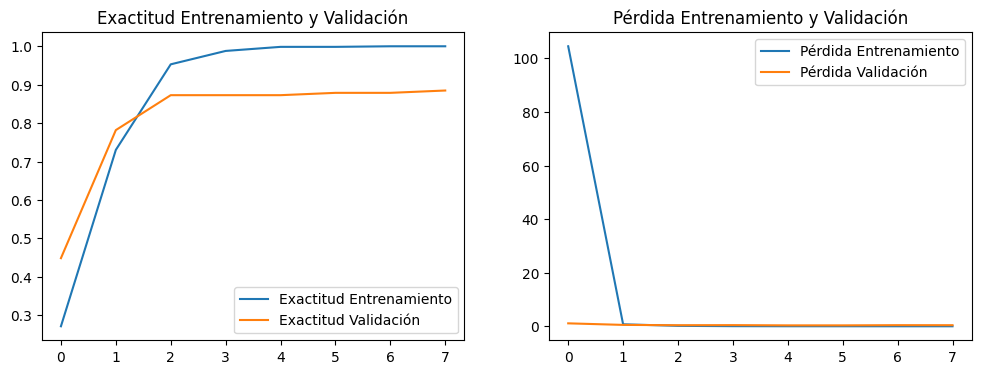

In [7]:
    # ============================
    # 4. Resultados de Exactitud de la RNAC
    # ============================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Exactitud Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Exactitud Validación')
    plt.legend(loc='lower right')
    plt.title('Exactitud Entrenamiento y Validación')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida Entrenamiento y Validación')
    plt.savefig("/content/training_validation_metrics.png")
    plt.show()

<IPython.core.display.Javascript object>

Imagen guardada en: photo.jpg


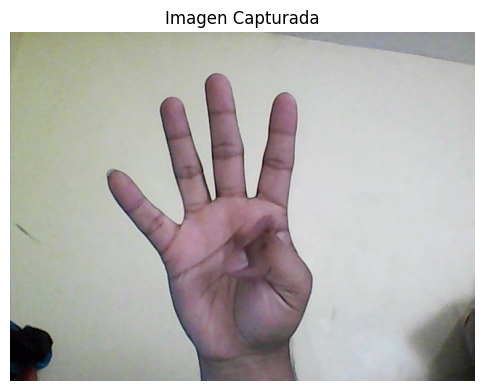

Forma de la imagen capturada: (480, 640, 3)
Forma de la imagen preprocesada: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predicción: Clase 3 ('Dedo 4') con confianza 100.0%


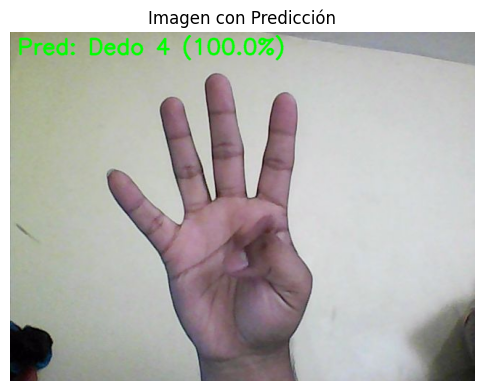

In [ ]:
# ============================
# 5. Predicciones con la RNAC y Captura de Imagen desde la Webcam (Colab)
# ============================
# Función para capturar una foto usando JavaScript (compatible con Colab).
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);
        const video = document.createElement('video');
        div.appendChild(video);
        document.body.appendChild(div);
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capturamos la imagen con la webcam mediante el widget y la guardamos en "photo.jpg".
filename = take_photo()
print("Imagen guardada en:", filename)

# Leemos la imagen capturada.
captured_img = cv2.imread(filename)
if captured_img is None:
    print("Error al leer la imagen capturada. Asegúrate de haber tomado la foto correctamente.")
else:
    # Mostrar la imagen capturada para depuración
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(captured_img, cv2.COLOR_BGR2RGB))
    plt.title("Imagen Capturada")
    plt.axis("off")
    plt.show()

    print("Forma de la imagen capturada:", captured_img.shape)

    # Función para preprocesar la imagen (redimensionarla, cambiar color, expandir dimensiones).
    def preprocess_frame(frame):
        frame_resized = cv2.resize(frame, IMG_SIZE)
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        frame_expanded = np.expand_dims(frame_rgb, axis=0)
        return frame_expanded

    # Preprocesamos la imagen capturada.
    photo_preprocessed = preprocess_frame(captured_img)
    print("Forma de la imagen preprocesada:", photo_preprocessed.shape)

    # Realizamos la predicción usando el modelo entrenado.
    predictions = model.predict(photo_preprocessed)
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    print(f"Predicción: Clase {predicted_class_index} ('{class_names[predicted_class_index]}') con confianza {confidence*100:.1f}%")

    # Agregamos la predicción sobre la imagen.
    annotated_img = captured_img.copy()
    cv2.putText(annotated_img,
                f"Pred: {class_names[predicted_class_index]} ({confidence*100:.1f}%)",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # Mostrar la imagen anotada
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(annotated_img_rgb)
    plt.axis("off")
    plt.title("Imagen con Predicción")
    plt.show()



Ejemplo de Predicciones con Imágenes de Validación:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


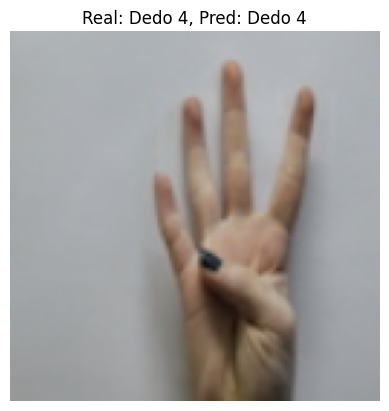

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


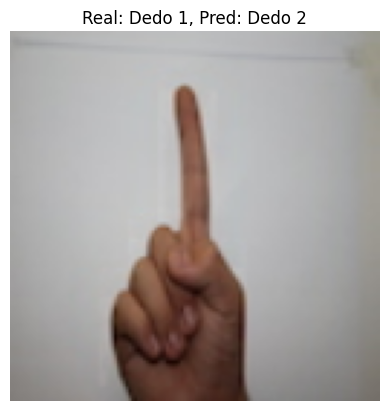

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


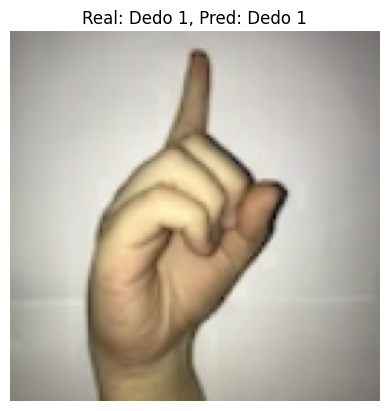


Skipping model training and subsequent steps because class_names was not successfully defined.


In [8]:
    # ============================
    # 6. Ejemplo de Predicciones con Imágenes de Validación
    # ============================
    if 'val_ds' in locals() and val_ds and 'class_names' in locals() and class_names:
        print("\nEjemplo de Predicciones con Imágenes de Validación:")
        for images, labels in val_ds.take(1):
            for i in range(min(3, images.shape[0])):
                image = images[i].numpy().astype("uint8")
                actual_label = labels[i].numpy()
                image_expanded = np.expand_dims(image, axis=0)
                prediction = model.predict(image_expanded)
                predicted_label_index = np.argmax(prediction[0])

                actual_label_name = class_names[actual_label] if actual_label < len(class_names) else f"Etiqueta {actual_label}"
                predicted_label_name = class_names[predicted_label_index] if predicted_label_index < len(class_names) else f"Clase {predicted_label_index}"

                plt.figure()
                plt.imshow(image)
                plt.title(f"Real: {actual_label_name}, Pred: {predicted_label_name}")
                plt.axis('off')
                plt.show()
    else:
         print("\nSkipping validation image predictions: val_ds or class_names not defined.")

    print("\nSkipping model training and subsequent steps because class_names was not successfully defined.")


In [ ]:
# Guardar el modelo en formato .h5
model.save("/content/model.h5")
print("Modelo guardado en /content/model.h5")

Modelo guardado en /content/model.h5


In [ ]:
from google.colab import files
files.download("/content/model.h5")

#Referencias



1.   https://github.com/dilp90/InteligenciaArtificial_y_RedesNeuronales_UANL_FIME/blob/main/EstructuraPIA/PIA_IAyRN.ipynb

2.   https://github.com/ardamavi/Sign-Language-Digits-Dataset/tree/master/Dataset

3.   https://keras.io/api/datasets/mnist/




# *Codigo Total

In [ ]:
# ============================
# 1. Importar Librerías
# ============================
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

# Importamos librerías para el método de captura vía JavaScript en Colab.
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Librería para montar Google Drive en Colab.
from google.colab import drive

# ============================
# 2. Montar Google Drive y Preprocesamiento
# ============================
# Montamos Google Drive para acceder al dataset.
drive.mount('/content/drive')

# Definimos la ruta al dataset en Drive.
# Se asume que tu dataset está organizado en:
# /content/drive/MyDrive/Datasets/Dataset/
# y que dentro existen subcarpetas (ej. 1, 2, 3, 4)
DATASET_PATH = "/content/drive/MyDrive/Datasets/Dataset"

# Verifica si la ruta existe para diagnosticar problemas.
if not os.path.exists(DATASET_PATH):
    print(f"Error: La ruta del dataset no existe: {DATASET_PATH}")
else:
    print("Contenido de la carpeta Dataset:", os.listdir(DATASET_PATH))

# Parámetros de preprocesamiento.
IMG_SIZE = (128,128)  # Se reduce la resolución para acelerar el entrenamiento.
BATCH_SIZE = 32       # Batch size moderado.

# Crea el dataset de entrenamiento y validación usando una partición 80/20.
try:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Guardamos las clases detectadas antes de aplicar optimizaciones.
    class_names = train_ds.class_names

    # Optimización del pipeline: cache y prefetch para evitar cargas repetidas en memoria.
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    print("Clases detectadas:", class_names)

except Exception as e:
    print(f"Error al crear el dataset: {e}")
    print("Asegúrate de que la ruta del dataset es correcta y contiene subcarpetas.")

# ============================
# 3. Estructura y Entrenamiento de la RNAC
# ============================
if 'class_names' in locals() and class_names:
    NUM_CLASSES = len(class_names)

    # Arquitectura simplificada para acelerar el entrenamiento.
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE + (3,)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compilamos el modelo.
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Entrenamiento del modelo (se reducen los epochs a 5 para acelerar).
    EPOCHS = 8
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

    # ============================
    # 4. Resultados de Exactitud de la RNAC
    # ============================
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Exactitud Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Exactitud Validación')
    plt.legend(loc='lower right')
    plt.title('Exactitud Entrenamiento y Validación')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida Entrenamiento y Validación')
    plt.savefig("/content/training_validation_metrics.png")
    plt.show()

    # ============================
    # 5. Predicciones con la RNAC y Captura de Imagen desde la Webcam (Colab)
  # ============================
  # Función para capturar una foto usando JavaScript (compatible con Colab).
  def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);
        const video = document.createElement('video');
        div.appendChild(video);
        document.body.appendChild(div);
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capturamos la imagen con la webcam mediante el widget y la guardamos en "photo.jpg".
filename = take_photo()
print("Imagen guardada en:", filename)

# Leemos la imagen capturada.
captured_img = cv2.imread(filename)
if captured_img is None:
    print("Error al leer la imagen capturada. Asegúrate de haber tomado la foto correctamente.")
else:
    # Mostrar la imagen capturada para depuración
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(captured_img, cv2.COLOR_BGR2RGB))
    plt.title("Imagen Capturada")
    plt.axis("off")
    plt.show()

    print("Forma de la imagen capturada:", captured_img.shape)

    # Función para preprocesar la imagen (redimensionarla, cambiar color, expandir dimensiones).
    def preprocess_frame(frame):
        frame_resized = cv2.resize(frame, IMG_SIZE)
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        frame_expanded = np.expand_dims(frame_rgb, axis=0)
        return frame_expanded

    # Preprocesamos la imagen capturada.
    photo_preprocessed = preprocess_frame(captured_img)
    print("Forma de la imagen preprocesada:", photo_preprocessed.shape)

    # Realizamos la predicción usando el modelo entrenado.
    predictions = model.predict(photo_preprocessed)
    predicted_class_index = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    print(f"Predicción: Clase {predicted_class_index} ('{class_names[predicted_class_index]}') con confianza {confidence*100:.1f}%")

    # Agregamos la predicción sobre la imagen.
    annotated_img = captured_img.copy()
    cv2.putText(annotated_img,
                f"Pred: {class_names[predicted_class_index]} ({confidence*100:.1f}%)",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # Mostrar la imagen anotada
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(annotated_img_rgb)
    plt.axis("off")
    plt.title("Imagen con Predicción")
    plt.show()

    # ============================
    # 6. Ejemplo de Predicciones con Imágenes de Validación
    # ============================
    if 'val_ds' in locals() and val_ds and 'class_names' in locals() and class_names:
        print("\nEjemplo de Predicciones con Imágenes de Validación:")
        for images, labels in val_ds.take(1):
            for i in range(min(3, images.shape[0])):
                image = images[i].numpy().astype("uint8")
                actual_label = labels[i].numpy()
                image_expanded = np.expand_dims(image, axis=0)
                prediction = model.predict(image_expanded)
                predicted_label_index = np.argmax(prediction[0])

                actual_label_name = class_names[actual_label] if actual_label < len(class_names) else f"Etiqueta {actual_label}"
                predicted_label_name = class_names[predicted_label_index] if predicted_label_index < len(class_names) else f"Clase {predicted_label_index}"

                plt.figure()
                plt.imshow(image)
                plt.title(f"Real: {actual_label_name}, Pred: {predicted_label_name}")
                plt.axis('off')
                plt.show()
    else:
         print("\nSkipping validation image predictions: val_ds or class_names not defined.")

    print("\nSkipping model training and subsequent steps because class_names was not successfully defined.")



1.   https://github.com/dilp90/InteligenciaArtificial_y_RedesNeuronales_UANL_FIME/blob/main/EstructuraPIA/PIA_IAyRN.ipynb

2.   https://github.com/ardamavi/Sign-Language-Digits-Dataset/tree/master/Dataset

3.   https://keras.io/api/datasets/mnist/




# Borrar

In [9]:
import socket  # Nueva librería para comunicación con ESP32

# Configuración de WiFi y ESP32
ESP32_IP = "192.168.1.100"  # Reemplaza con la IP de tu ESP32
ESP32_PORT = 8080

def send_prediction_to_esp32(prediction):
    try:
        # Crear conexión con ESP32
        esp_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        esp_socket.connect((ESP32_IP, ESP32_PORT))

        # Enviar la predicción como cadena
        esp_socket.sendall(str(prediction).encode())

        # Cerrar conexión
        esp_socket.close()
        print(f"Predicción enviada al ESP32: {prediction}")
    except Exception as e:
        print(f"Error al enviar datos a ESP32: {e}")

# ============================
# 5. Predicción y Envío al ESP32
# ============================
if captured_img is not None:
    # Realizamos la predicción usando el modelo entrenado.
    predictions = model.predict(photo_preprocessed)
    predicted_class_index = np.argmax(predictions[0])

    # Obtener la etiqueta correspondiente al número
    predicted_label = class_names[predicted_class_index]

    # Mostramos la predicción
    print(f"Predicción: {predicted_label} (Clase {predicted_class_index})")

    # Enviar la predicción al ESP32
    send_prediction_to_esp32(predicted_class_index)


NameError: name 'captured_img' is not defined